In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
import shap
mm = MinMaxScaler()
ss = StandardScaler()



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/2022-1/기계학습/master_4_lite.csv')
df.head() 

,gender,age,outcome_inhospital_mortality,outcome_hospitalization,n_hosp_365d,n_icu_365d,ed_los_hours,triage_resprate,triage_sbp,triage_acuity,...,ed_heartrate_last,ed_resprate_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,stay_id,score_CCI,outcome_critical
0,0,49,False,True,0,0,16.12,16.0,186.0,2.0,...,65.0,16.0,137.0,97.0,0.0,1.0,4.0,39558534,0,False
1,1,67,False,True,26,0,17.05,15.0,122.0,3.0,...,63.0,18.0,155.0,71.0,0.0,2.0,0.0,37706150,5,False
2,0,24,False,False,0,0,0.07,16.0,123.0,4.0,...,59.0,16.0,119.0,66.0,5.0,1.0,2.0,32740385,0,False
3,1,58,False,False,0,0,0.15,18.0,139.0,3.0,...,77.0,17.0,126.0,73.0,0.0,0.0,0.0,37440017,4,False
4,0,23,False,False,0,0,0.13,18.0,107.0,3.0,...,81.0,16.0,116.0,76.0,0.0,1.0,4.0,36963498,0,False


In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df['critical_result'] = df.iloc[:,9]

C:\Users\woghs\AppData\Local\Temp\ipykernel_19120\383542322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['critical_result'] = df.iloc[:,9]


In [6]:
#xbbost를 위해 x y 로 데이터 분리 후 dmatrix로 변환 (y=치명적인지 아닌지)
X, y = df.iloc[:,1:-1],df.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)


In [ ]:
X

,outcome_inhospital_mortality,outcome_hospitalization,n_hosp_365d,n_icu_365d,ed_los_hours,triage_resprate,triage_sbp,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_fever_chills,ed_heartrate_last,ed_resprate_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,stay_id,score_CCI
gender,,,,,,,,,,,,,,,,,,,,
0,False,True,0,0,16.12,16.0,186.0,2.0,True,False,False,65.0,16.0,137.0,97.0,0.0,1.0,4.0,39558534,0
1,False,True,26,0,17.05,15.0,122.0,3.0,False,False,False,63.0,18.0,155.0,71.0,0.0,2.0,0.0,37706150,5
0,False,False,0,0,0.07,16.0,123.0,4.0,False,False,False,59.0,16.0,119.0,66.0,5.0,1.0,2.0,32740385,0
1,False,False,0,0,0.15,18.0,139.0,3.0,False,False,False,77.0,17.0,126.0,73.0,0.0,0.0,0.0,37440017,4
0,False,False,0,0,0.13,18.0,107.0,3.0,False,False,False,81.0,16.0,116.0,76.0,0.0,1.0,4.0,36963498,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,False,True,0,0,2.20,18.0,133.0,1.0,False,False,False,66.0,18.0,92.0,55.0,0.0,5.0,0.0,35130402,2
0,False,True,0,0,0.67,20.0,125.0,1.0,False,False,False,77.0,17.0,126.0,73.0,0.0,3.0,0.0,37041181,3
0,False,True,1,1,4.47,20.0,129.0,1.0,False,False,False,100.0,15.0,126.0,54.0,3.0,8.0,0.0,37929752,7


# 최적화 x

In [7]:

xgb_clf = xgb.XGBClassifier()

model=XGBClassifier(booster='gbtree', 
                    colsample_bylevel=0.9, 
                    colsample_bytree=0.8, 
                    gamma=2, 
                    max_depth=9, 
                    min_child_weight=3, 
                    n_estimators=50, 
                    nthread=3, 
                    objective='binary:logistic', 
                   random_state=200, 
                    silent= True)

model.fit(X_train, y_train,verbose=False)

XGBClassifier(colsample_bylevel=0.9, colsample_bytree=0.8, gamma=2, max_depth=9,
              min_child_weight=3, n_estimators=50, nthread=3, random_state=200,
              silent=True)

In [10]:
#모델 예측
y_pred = model.predict(X_test)
y_true = y_test

acc = accuracy_score(y_true, y_pred)
con_mat = confusion_matrix(y_true, y_pred)
con_mat
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.91      0.85      0.88      5848
        True       0.86      0.91      0.89      5986

    accuracy                           0.88     11834
   macro avg       0.89      0.88      0.88     11834
weighted avg       0.89      0.88      0.88     11834



In [ ]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

# 최적화 O

In [ ]:

xgb_clf = xgb.XGBClassifier()

#초모수 격자생성
xgb_param_grid = {   
                    
                    'gamma':[0,1,2,3], 
                    'max_depth':[5,7,10], 
                    'min_child_weight':[2], 
                    'n_estimators':[50,100], 
                    'nthread':[2,3,7],                    
                    'random_state':[200,250] 
                    }
#GridSearchCV 객체 생성
hr_grid = GridSearchCV(estimator=xgb_clf,
                       param_grid=xgb_param_grid,
                       scoring='roc_auc',
                       n_jobs=8,
                      cv=5,
                    refit=True, 
                     return_train_score=True)
hr_grid.fit(X_train, y_train)
##model=XGBClassifier(booster='gbtree', 
                #    colsample_bylevel=0.9, 
                #    colsample_bytree=0.8, 
                #    gamma=2, 
                #    max_depth=9, 
                #    min_child_weight=3, 
                #    n_estimators=50, 
                #    nthread=3, 
                #    objective='binary:logistic', 
                #   random_state=200, 
                #    silent= True)

#model.fit(X_train, y_train,verbose=False)

KeyboardInterrupt: 

In [ ]:
## 최고성능
best_score = hr_grid.best_score_
# 최고성능을 내는 행을 찾아냄
best_row = hr_grid.best_index_

# 최적 초모수: max_depth, subsample
best_max_depth     = hr_grid.best_params_["max_depth"]
best_max_gamma = hr_grid.best_params_["gamma"]
best_max_min_child_weight= hr_grid.best_params_["min_child_weight"]
best_max_n_estimators= hr_grid.best_params_["n_estimators"]
best_max_nthread= hr_grid.best_params_["nthread"]
best_max_random_state= hr_grid.best_params_["random_state"]


#nl = '\n'
#print(f 'AUC:  \t {best_score:.6f}{nl}\
#         index:           \t {best_row}{nl}\
#         max_depth:      \t {max_depth}{nl}\
#         gamma :    \t{gamma}{nl}\
#         min_child_weight: \t{min_child_weight}{nl}\
#         n_estimators:  \t{n_estimators}{nl}\
#         nthread :   \t{nthread}{nl}\
#         random_state:  \t{random_state}'
#     )

# SHAP 그래프를 통한 Explainable AI

### force plot을 통한 shaply value를 1차원 평면에 정렬

In [13]:

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

#### 긍정 영향 -> 빨강색 , 부정 영향 -> 파랑색

In [12]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, shap_values[0, :10], X_train.iloc[0, :10])

TypeError: ignored

#### 전체 데이터 shaply value 누적 시각화

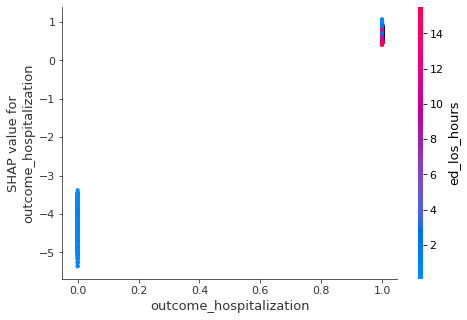

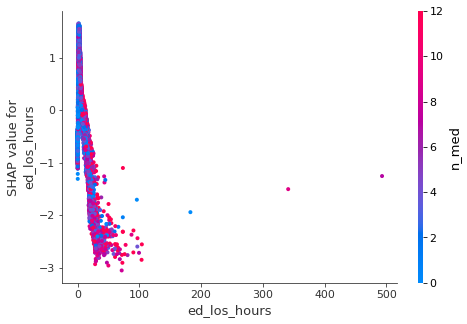

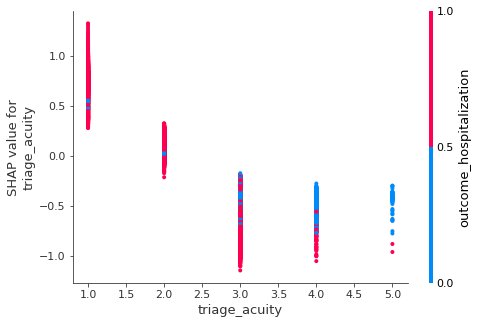

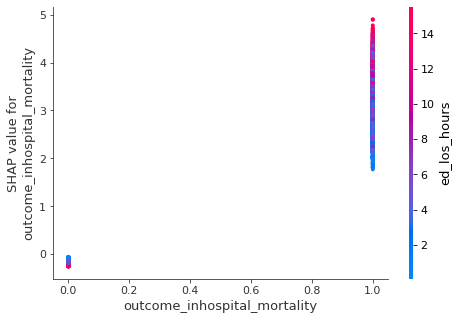

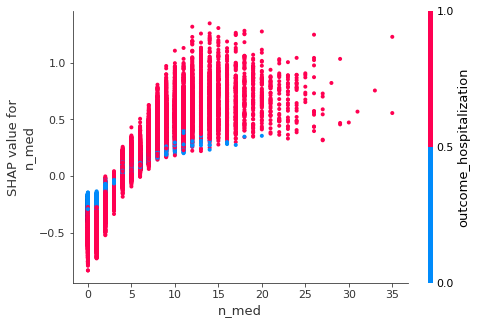

In [16]:
shap.initjs()
# 총 13개 특성의 Shapley value를 절댓값 변환 후 각 특성마다 더함 -> np.argsort()는 작은 순서대로 정렬, 큰 순서대로 정렬하려면
# 앞에 마이너스(-) 기호를 붙임
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# 영향력 top 5 컬럼
for i in range(5):
    shap.dependence_plot(top_inds[i], shap_values, X_train)

#### 전체 특성들이 Shapley value 분포에 어떤 영향을 미치는지 시각화 

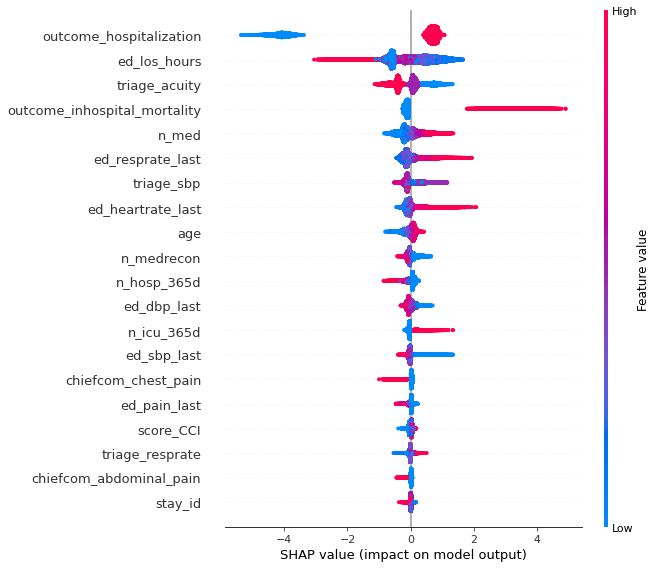

In [17]:
shap.summary_plot(shap_values, X_train)

#### 각 특성이 모델이 미치는 절대 영향도(기여도)

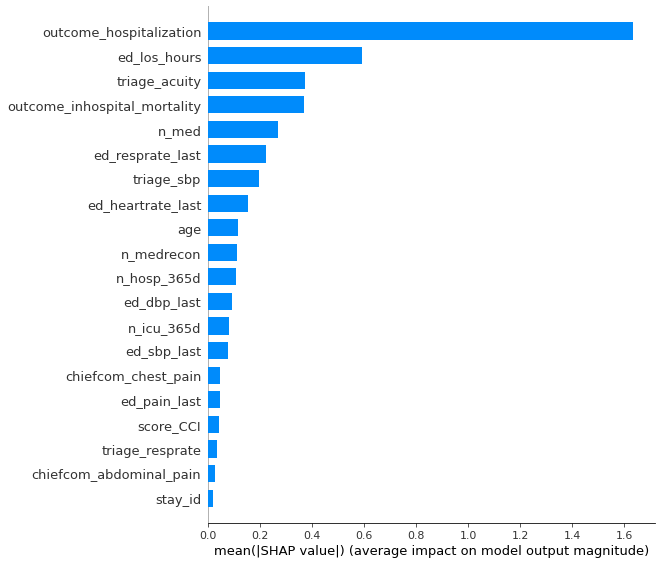

In [18]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

#### 각 특성간의 상호작용 효과 확인

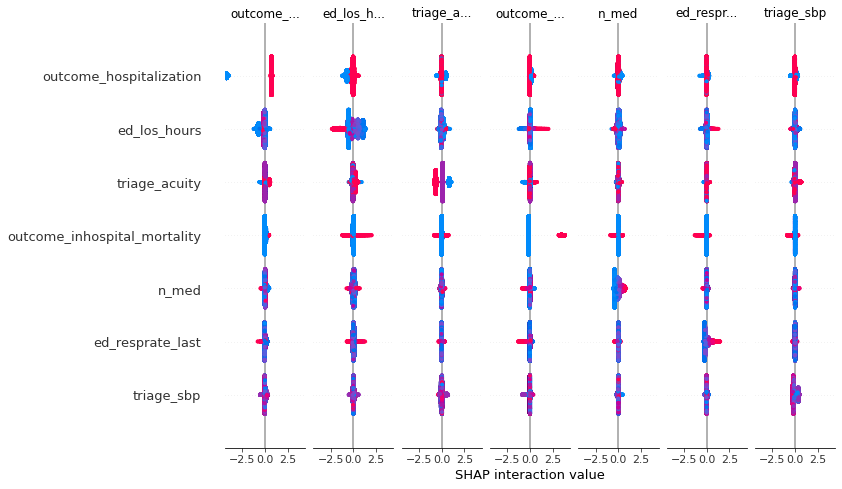

In [19]:
shap_interaction_values = explainer.shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values, X_train)